<a href="https://colab.research.google.com/github/carpetmat/Class-Activity_Project-1/blob/master/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project 1**

Here is a helpful page: https://oceanobservatories.org/ooi-m2m-interface/

Timestamp conversion code found here: https://github.com/ooi-data-review/2018-data-workshops/blob/master/chemistry/examples/extras2/Synchronous_Requests_and_Basic_Plotting.ipynb

I used this method specifically: https://github.com/ooi-data-review/2018-data-workshops/blob/master/chemistry/examples/extras2/Using_the_OOI_API_with_Python.ipynb

## Import ALL the things

In [1]:
#Some of these imorts may no longer be relevant, will weed out useless improts later.
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
import os
import re
import pandas as pd
import time
import json
!pip install thredds_crawler
from thredds_crawler.crawl import Crawl


My OOI API info, and base url.

In [0]:
API_USERNAME = 'OOIAPI-4VTWFS3K3O00B9'
API_TOKEN = 'TEMP-TOKEN-C4MWINON0JLKT1'

In [0]:
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

## Set up our reusable functions

In [0]:
# A quick function to make an API request and print the results
def get_and_print_api(url):
  r = requests.get(url, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  for d in data:
    print( d )

In [0]:
# Time Processing Routine
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

In [0]:
# Data request and download
def Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN):

  data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  Data_url_add_to_queue = r.json()
  #Data_url_add_to_queue = datacheck['allURLs'][0]
  
  return Data_url_add_to_queue

In [0]:
 def Check_and_Pull(datacheck):

  #For some reason uncommenting this next line breaks the code. Though it works fine when it is within it's own cell.
  #%%time
  
  #This is the part that checls to ensure the link is ready to go.
  check_complete = datacheck['allURLs'][1] + '/status.txt'
  for i in range(1000): 
      r = requests.get(check_complete)
      if r.status_code == requests.codes.ok:
          print('request completed')
          break
      else:
          time.sleep(.5)

  #This part then finds and downloads the requested csv file.
  url = datacheck['allURLs'][0]
  c = Crawl(url, select=['.*\.csv$'], debug=False)
  urls = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
  #print(urls)
  data = pd.read_csv(urls[0])
  #data

  #No need to check headers for this, forutnately
  Time = data.time

  #Convert timestamp to datetime
  Time = Time.apply(ntp_seconds_to_datetime)
  #Now cut off the "date" part of the datetime (I'm sure there was a single line way to do this, Oh well).
  Time = pd.Series([val.time() for val in Time])

  #Now that we theoretically just got data, lets create a data frame we can export
  Data_Return = pd.DataFrame((),
                              columns=['Time','Depth', 'Temperature', 'Salinity', 'SpeedOfSound'])
  Data_Return.Time = Time
  #Lets check to see if we can find the correct headers when pulling data
  #For Pressure
  if ('seawater_pressure' in data):
    Data_Return.Depth = data.seawater_pressure
  else:
    Data_Return.Depth = data.pressure

  #For Temperature
  if ('seawater_temperature' in data):
    Data_Return.Temperature = data.seawater_temperature
  elif ('temp' in data):
    Data_Return.Temperature = data.temp
  else:
    Data_Return.Temperature = data.temperature
    
  #For Salinity
  if ('practical_salinity' in data):
    Data_Return.Salinity = data.practical_salinity
  else:
    Data_Return.Salinity = data.salinity

  Data_Return.SpeedOfSound = 1449.2 + 4.6*Data_Return.Temperature - 0.055*Data_Return.Temperature**2 + 0.00029*Data_Return.Temperature**3 + (1.34 - 0.01 * Data_Return.Temperature)*(Data_Return.Salinity - 35) + 0.016*Data_Return.Depth

  return Data_Return

# Find Information on the sensor thingys

In [0]:
# r = requests.get(SENSOR_BASE_URL, auth=(API_USERNAME, API_TOKEN))
# print( r.status_code )
# print( r.headers )
# print( r.encoding )
# print( r.text )
# print( r.json() )

In [0]:
# sites = r.json()
# for site in sites:
#   print( site )

In [0]:
# #CE04OSPD-DP01B-01-CTDPFL105
# get_and_print_api(SENSOR_BASE_URL+'/CE04OSPS')

In [0]:
# #CE04OSPD-DP01B-01-CTDPFL105
# #List of Nodes for a Site
# get_and_print_api(SENSOR_BASE_URL+'/CE04OSPS/SF01B')

In [0]:
# #CE04OSPD-DP01B-01-CTDPFL105
# #List of Sensors (Instruments) for a Node
# get_and_print_api(SENSOR_BASE_URL+'/CE04OSPS/SF01B')

In [0]:
# #CE04OSPD-DP01B-01-CTDPFL105
# #List of Methods for a Sensor
# get_and_print_api(SENSOR_BASE_URL+'/CE04OSPS/SF01B/2A-CTDPFA107')

In [0]:
# #CE04OSPD-DP01B-01-CTDPFL105
# #List of Data Streams for a Method
# get_and_print_api(SENSOR_BASE_URL+'/CE04OSPS/SF01B/2A-CTDPFA107/streamed')

# Information from my selceted Data Ranges for each instrument

### Summer:


**1: Oregon Shelf Surface Piercing Profiler Mooring**
*   CE02SHSP-SP001-08-CTDPFJ000
*   recovered-cspp
*   ctdpf_j_cspp_instrument_recovered
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**2: Oregon Offshore Cabled Shallow Profiler Mooring**
*   CE04OSPS-SF01B-2A-CTDPFA107
*   streamed
*   ctdpf_sbe43_sample
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**3: Oregon Offshore Cabled Deep Profiler Mooring**
*   CE04OSPD-DP01B-01-CTDPFL105
*   recovered-inst
*   dpc_ctd_instrument_recovered
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**4: Oregon Slope Base Shallow Profiler**
*   RS01SBPS-SF01A-2A-CTDPFA102
*   streamed
*   ctdpf_sbe43_sample
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**5: Oregon Slope Base Deep Profiler**
*   RS01SBPD-DP01A-01-CTDPFL104
*   recovered-inst
*   dpc_ctd_instrument_recovered
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**6: Axial Base Shallow Profiler**
*   RS03AXPS-SF03A-2A-CTDPFA302
*   streamed
*   ctdpf_sbe43_sample
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**7: Axial Base Deep Profiler**
*   RS03AXPD-DP03A-01-CTDPFL304
*   recovered-inst
*   dpc_ctd_instrument_recovered
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000


## Winter:

**1: Oregon Shelf Surface Piercing Profiler Mooring**
*   CE02SHSP-SP001-08-CTDPFJ000
*   recovered-cspp
*   ctdpf_j_cspp_instrument_recovered
*   2017-12-15 00:00:00.000
*   2017-12-16 00:00:00.000

**2: Oregon Offshore Cabled Shallow Profiler Mooring**
*   CE04OSPS-SF01B-2A-CTDPFA107
*   streamed
*   ctdpf_sbe43_sample
*   2018-12-15 00:00:00.000
*   2018-12-16 00:00:00.000

**3: Oregon Offshore Cabled Deep Profiler Mooring**
*   CE04OSPD-DP01B-01-CTDPFL105
*   recovered-wfp
*   dpc_ctd_instrument_recovered
*   2015-12-15 00:00:00.000
*   2015-12-16 00:00:00.000

**4: Oregon Slope Base Shallow Profiler**
*   RS01SBPS-SF01A-2A-CTDPFA102
*   streamed
*   ctdpf_sbe43_sample
*   2018-12-15 00:00:00.000
*   2018-12-16 00:00:00.000

**5: Oregon Slope Base Deep Profiler**
*   RS01SBPD-DP01A-01-CTDPFL104
*   recovered-wfp
*   dpc_ctd_instrument_recovered
*   2015-12-15 00:00:00.000
*   2015-12-16 00:00:00.000

**6: Axial Base Shallow Profiler**
*   RS03AXPS-SF03A-2A-CTDPFA302
*   streamed
*   ctdpf_sbe43_sample
*   2019-12-15 00:00:00.000
*   2019-12-16 00:00:00.000

**7: Axial Base Deep Profiler**
*   RS03AXPD-DP03A-01-CTDPFL304
*   recovered-inst
*   dpc_ctd_instrument_recovered
*   2019-12-15 00:00:00.000
*   2019-12-16 00:00:00.000


# Data Requests

## 1: Oregon Shelf Surface Piercing Profiler Mooring

### **Summer:**

In [0]:
# CE02SHSP-SP001-08-CTDPFJ000
# recovered_cspp
# ctdpf_j_cspp_instrument_recovered
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'CE02SHSP'
node = 'SP001'
instrument = '08-CTDPFJ000'
method = 'recovered_cspp'
stream = 'ctdpf_j_cspp_instrument_recovered'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue1S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# CE02SHSP-SP001-08-CTDPFJ000
# recovered_cspp
# ctdpf_j_cspp_instrument_recovered
# 2017-12-15 00:00:00.000
# 2017-12-16 00:00:00.000

#Instrument Information
site = 'CE02SHSP'
node = 'SP001'
instrument = '08-CTDPFJ000'
method = 'recovered_cspp'
stream = 'ctdpf_j_cspp_instrument_recovered'

params = {
    'beginDT':'2017-12-15T00:00:00.000Z',
    'endDT':'2017-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue1W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 2: Oregon Offshore Cabled Shallow Profiler Mooring

### **Summer:**

In [0]:
# CE04OSPS-SF01B-2A-CTDPFA107
# streamed
# ctdpf_sbe43_sample
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'CE04OSPS'
node = 'SF01B'
instrument = '2A-CTDPFA107'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue2S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# CE04OSPS-SF01B-2A-CTDPFA107
# streamed
# ctdpf_sbe43_sample
# 2018-12-15 00:00:00.000
# 2018-12-16 00:00:00.000

#Instrument Information
site = 'CE04OSPS'
node = 'SF01B'
instrument = '2A-CTDPFA107'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2018-12-15T00:00:00.000Z',
    'endDT':'2018-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue2W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 3: Oregon Offshore Cabled Deep Profiler Mooring

### **Summer:**

In [0]:
# CE04OSPD-DP01B-01-CTDPFL105
# recovered_inst
# dpc_ctd_instrument_recovered
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'CE04OSPD'
node = 'DP01B'
instrument = '01-CTDPFL105'
method = 'recovered_inst'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
   'format':'application/csv',
}

Data_url_add_to_queue3S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# CE04OSPD-DP01B-01-CTDPFL105
# recovered_wfp
# dpc_ctd_instrument_recovered
# 2015-12-15 00:00:00.000
# 2015-12-16 00:00:00.000

#Instrument Information
site = 'CE04OSPD'
node = 'DP01B'
instrument = '01-CTDPFL105'
method = 'recovered_wfp'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2015-12-15T00:00:00.000Z',
    'endDT':'2015-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue3W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 4: Oregon Slope Base Shallow Profiler

### **Summer:**

In [0]:
# RS01SBPS-SF01A-2A-CTDPFA102
# streamed
# ctdpf_sbe43_sample
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'RS01SBPS'
node = 'SF01A'
instrument = '2A-CTDPFA102'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue4S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# RS01SBPS-SF01A-2A-CTDPFA102
# streamed
# ctdpf_sbe43_sample
# 2018-12-15 00:00:00.000
# 2018-12-16 00:00:00.000

#Instrument Information
site = 'RS01SBPS'
node = 'SF01A'
instrument = '2A-CTDPFA102'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2018-12-15T00:00:00.000Z',
    'endDT':'2018-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue4W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 5: Oregon Slope Base Deep Profiler

### **Summer:**

In [0]:
# RS01SBPD-DP01A-01-CTDPFL104
# recovered_inst
# dpc_ctd_instrument_recovered
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'RS01SBPD'
node = 'DP01A'
instrument = '01-CTDPFL104'
method = 'recovered_inst'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue5S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# RS01SBPD-DP01A-01-CTDPFL104
# recovered_wfp
# dpc_ctd_instrument_recovered
# 2015-12-15 00:00:00.000
# 2015-12-16 00:00:00.000

#Instrument Information
site = 'RS01SBPD'
node = 'DP01A'
instrument = '01-CTDPFL104'
method = 'recovered_wfp'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2015-12-15T00:00:00.000Z',
    'endDT':'2015-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue5W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 6: Axial Base Shallow Profiler

### **Summer:**

In [0]:
# RS03AXPS-SF03A-2A-CTDPFA302
# streamed
# ctdpf_sbe43_sample
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'RS03AXPS'
node = 'SF03A'
instrument = '2A-CTDPFA302'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue6S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# RS03AXPS-SF03A-2A-CTDPFA302
# streamed
# ctdpf_sbe43_sample
# 2019-12-15 00:00:00.000
# 2019-12-16 00:00:00.000

#Instrument Information
site = 'RS03AXPS'
node = 'SF03A'
instrument = '2A-CTDPFA302'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2019-12-15T00:00:00.000Z',
    'endDT':'2019-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue6W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 7: Axial Base Deep Profiler


### **Summer:**

In [0]:
# RS03AXPD-DP03A-01-CTDPFL304
# recovered-inst
# dpc_ctd_instrument_recovered
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'RS03AXPD'
node = 'DP03A'
instrument = '01-CTDPFL304'
method = 'recovered_inst'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue7S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# RS03AXPD-DP03A-01-CTDPFL304
# recovered_inst
# dpc_ctd_instrument_recovered
# 2019-12-15 00:00:00.000
# 2019-12-16 00:00:00.000

#Instrument Information
site = 'RS03AXPD'
node = 'DP03A'
instrument = '01-CTDPFL304'
method = 'recovered_inst'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2019-12-15T00:00:00.000Z',
    'endDT':'2019-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue7W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

# Data Table Construction

In [0]:
#Desperate times call for desperate measures. Forgive me for I am about to sin:

Table1S = Check_and_Pull(Data_url_add_to_queue1S)
Table1W = Check_and_Pull(Data_url_add_to_queue1W)

Table2S = Check_and_Pull(Data_url_add_to_queue2S)
Table2W = Check_and_Pull(Data_url_add_to_queue2W)

Table3S = Check_and_Pull(Data_url_add_to_queue3S)
Table3W = Check_and_Pull(Data_url_add_to_queue3W)

Table4S = Check_and_Pull(Data_url_add_to_queue4S)
Table4W = Check_and_Pull(Data_url_add_to_queue4W)

Table5S = Check_and_Pull(Data_url_add_to_queue5S)
Table5W = Check_and_Pull(Data_url_add_to_queue5W)

Table6S = Check_and_Pull(Data_url_add_to_queue6S)
Table6W = Check_and_Pull(Data_url_add_to_queue6W)

Table7S = Check_and_Pull(Data_url_add_to_queue7S)
Table7W = Check_and_Pull(Data_url_add_to_queue7W)

# Print ALL the graphs

## For Summer

Text(0.5, 1.0, 'Depth vs Time')

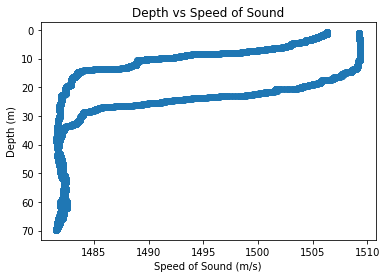

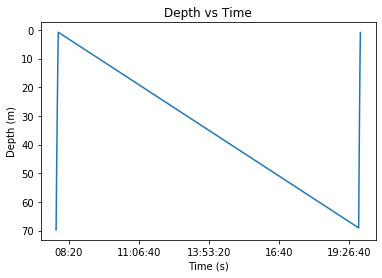

In [40]:
#DON'T QUESTION IT, JUST PRINT. WE AIN'T GOT TIME TO LOOP DIS CRAP ALL PRETTY LIKE
fig = plt.figure()
X1 = Table1S.SpeedOfSound
Y1 = Table1S.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table1S.Time
Y2 = Table1S.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

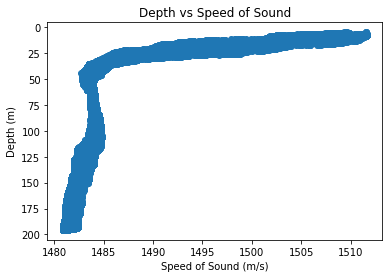

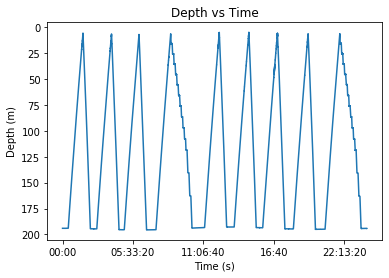

In [41]:
fig = plt.figure()
X1 = Table2S.SpeedOfSound
Y1 = Table2S.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table2S.Time
Y2 = Table2S.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

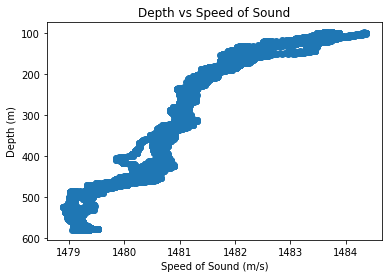

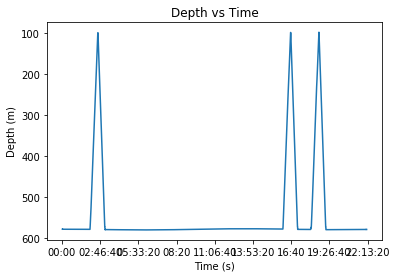

In [42]:
fig = plt.figure()
X1 = Table3S.SpeedOfSound
Y1 = Table3S.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table3S.Time
Y2 = Table3S.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

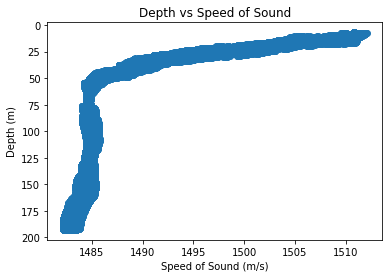

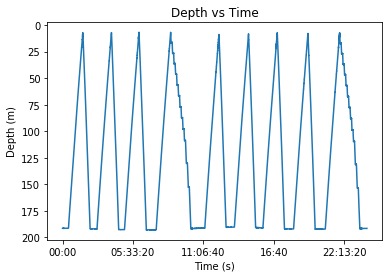

In [43]:
fig = plt.figure()
X1 = Table4S.SpeedOfSound
Y1 = Table4S.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table4S.Time
Y2 = Table4S.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

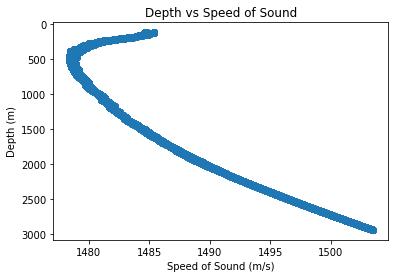

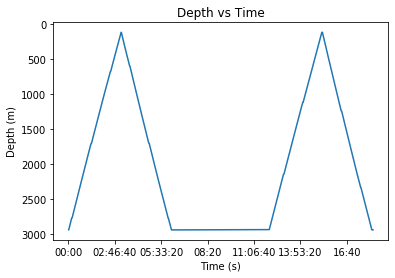

In [44]:
fig = plt.figure()
X1 = Table5S.SpeedOfSound
Y1 = Table5S.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table5S.Time
Y2 = Table5S.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

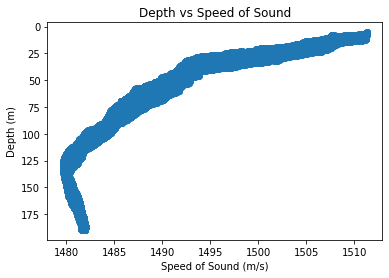

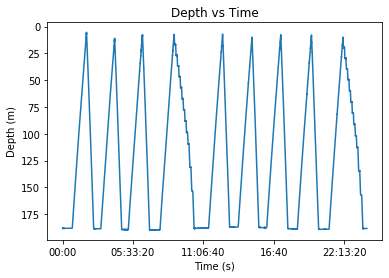

In [45]:
fig = plt.figure()
X1 = Table6S.SpeedOfSound
Y1 = Table6S.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table6S.Time
Y2 = Table6S.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

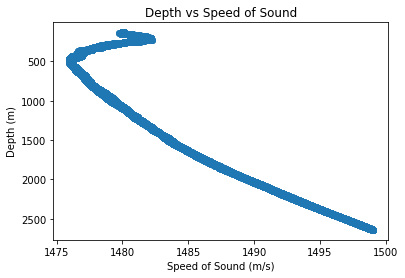

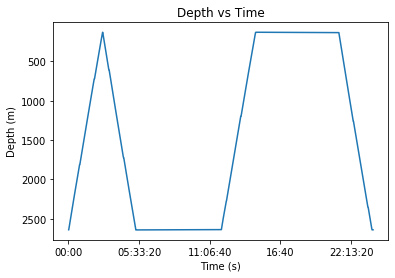

In [46]:
fig = plt.figure()
X1 = Table7S.SpeedOfSound
Y1 = Table7S.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table7S.Time
Y2 = Table7S.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

## For Winter

Text(0.5, 1.0, 'Depth vs Time')

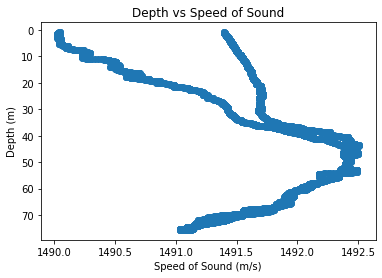

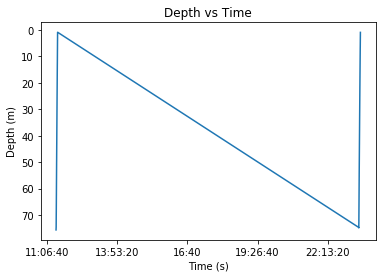

In [47]:
#DON'T QUESTION IT, JUST PRINT. WE AIN'T GOT TIME TO LOOP DIS CRAP ALL PRETTY LIKE
fig = plt.figure()
X1 = Table1W.SpeedOfSound
Y1 = Table1W.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table1W.Time
Y2 = Table1W.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

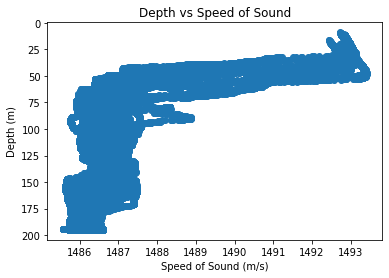

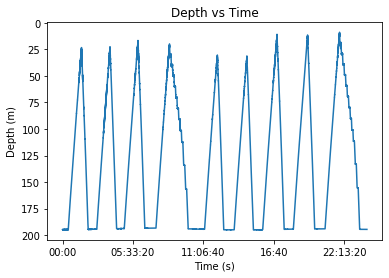

In [48]:
fig = plt.figure()
X1 = Table2W.SpeedOfSound
Y1 = Table2W.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table2W.Time
Y2 = Table2W.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

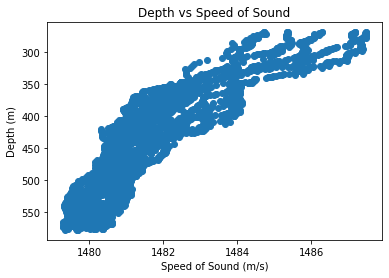

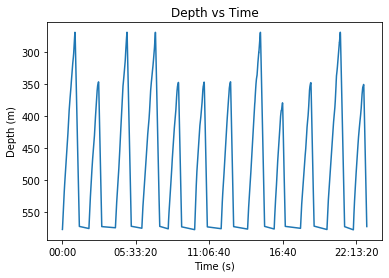

In [49]:
fig = plt.figure()
X1 = Table3W.SpeedOfSound
Y1 = Table3W.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table3W.Time
Y2 = Table3W.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

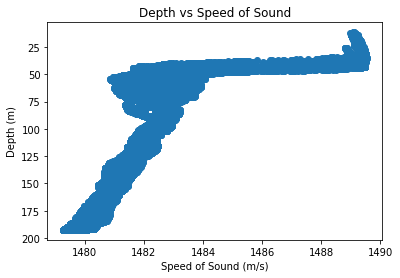

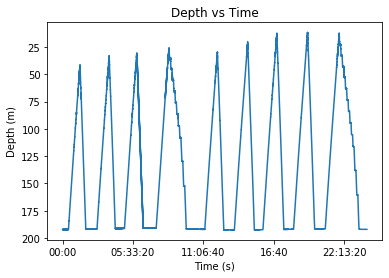

In [50]:
fig = plt.figure()
X1 = Table4W.SpeedOfSound
Y1 = Table4W.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table4W.Time
Y2 = Table4W.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

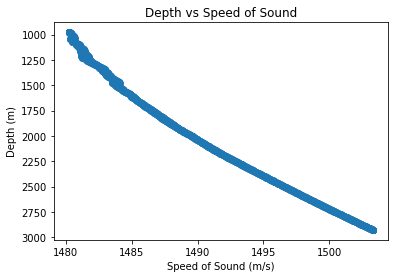

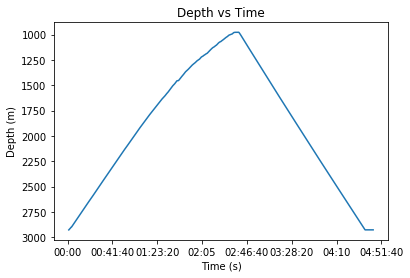

In [51]:
fig = plt.figure()
X1 = Table5W.SpeedOfSound
Y1 = Table5W.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table5W.Time
Y2 = Table5W.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

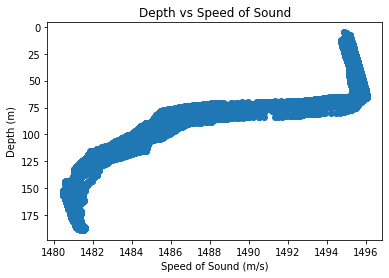

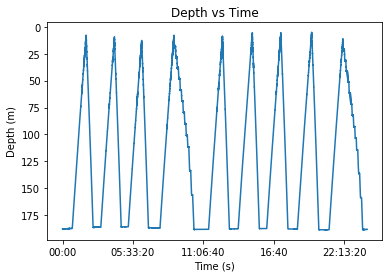

In [52]:
fig = plt.figure()
X1 = Table6W.SpeedOfSound
Y1 = Table6W.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table6W.Time
Y2 = Table6W.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

Text(0.5, 1.0, 'Depth vs Time')

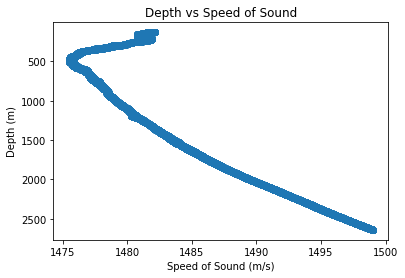

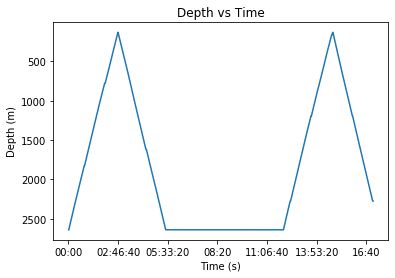

In [53]:
fig = plt.figure()
X1 = Table7W.SpeedOfSound
Y1 = Table7W.Depth
plt.scatter(X1,Y1)
plt.gca().invert_yaxis()
plt.xlabel('Speed of Sound (m/s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Speed of Sound')

fig = plt.figure()
X2 = Table7W.Time
Y2 = Table7W.Depth
plt.plot(X2,Y2)
plt.gca().invert_yaxis()
plt.xlabel('Time (s)')
plt.ylabel('Depth (m)')
plt.title('Depth vs Time')

#The end

# Backup functions for when code fails and I ugly cry

In [0]:
# # Data request and download
# def Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN):

#   data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))
#   r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
#   datacheck = r.json()

#   #For some reason uncommenting this next line breaks the code. Though it works fine when it is within it's own cell.
#   #%%time
  
#   #This is the part that checls to ensure the link is ready to go.
#   check_complete = datacheck['allURLs'][1] + '/status.txt'
#   for i in range(1000): 
#       r = requests.get(check_complete)
#       if r.status_code == requests.codes.ok:
#           print('request completed')
#           break
#       else:
#           time.sleep(.5)

#   #This part then finds and downloads the requested csv file.
#   url = datacheck['allURLs'][0]
#   c = Crawl(url, select=['.*\.csv$'], debug=False)
#   urls = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
#   #print(urls)
#   data = pd.read_csv(urls[0])
#   #data

#   #No need to check headers for this, forutnately
#   Time = data.time

#   #Convert timestamp to datetime
#   Time = Time.apply(ntp_seconds_to_datetime)
#   #Now cut off the "date" part of the datetime (I'm sure there was a single line way to do this, Oh well).
#   Time = pd.Series([val.time() for val in Time])

#   #Now that we theoretically just got data, lets create a data frame we can export
#   Data_Return = pd.DataFrame((),
#                               columns=['Time','Depth', 'Temperature', 'Salinity', 'SpeedOfSound'])
#   Data_Return.Time = Time
#   #Lets check to see if we can find the correct headers when pulling data
#   #For Pressure
#   if ('seawater_pressure' in data):
#     Data_Return.Depth = data.seawater_pressure
#   else:
#     Data_Return.Depth = data.pressure

#   #For Temperature
#   if ('seawater_temperature' in data):
#     Data_Return.Temperature = data.seawater_temperature
#   elif ('temp' in data):
#     Data_Return.Temperature = data.temp
#   else:
#     Data_Return.Temperature = data.temperature
    
#   #For Salinity
#   if ('practical_salinity' in data):
#     Data_Return.Salinity = data.practical_salinity
#   else:
#     Data_Return.Salinity = data.salinity

#   Data_Return.SpeedOfSound = 1449.2 + 4.6*Temperature - 0.055*Temperature**2 + 0.00029*Temperature**3 + (1.34 - 0.01 * Temperature)*(Salinity - 35) + 0.016*Depth

#   return Data_Return

In [0]:
# # CE02SHSP-SP001-08-CTDPFJ000
# # recovered_cspp
# # ctdpf_j_cspp_instrument_recovered
# # 2019-07-15 00:00:00.000
# # 2019-07-16 00:00:00.000

# #Instrument Information
# site = 'CE02SHSP'
# node = 'SP001'
# instrument = '08-CTDPFJ000'
# method = 'recovered_cspp'
# stream = 'ctdpf_j_cspp_instrument_recovered'

# params = {
#     'beginDT':'2019-07-15T00:00:00.000Z',
#     'endDT':'2019-07-16T00:00:00.000Z',
#     'format':'application/csv',
# }


#Requested_Data = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)
#Requested_Data

##Working Example

In [0]:
#The comments below are information I have manually aquired, as automanting it seems like a whole new level of tricky.
#CE04OSPS-SF01B-2A-CTDPFA107
#streamed
#ctdpf_sbe43_sample
#2017-07-15 00:00:00.000
#2017-07-16 00:00:00.000

# # Instrument Information
# site='CE02SHSP'
# node = 'SP001'
# instrument = '08-CTDPFJ000'
# method='recovered_cspp'
# stream='ctdpf_j_cspp_instrument_recovered'
# params = {
#   'beginDT':'2017-01-04T08:02:59.950Z',
#   'endDT':'2017-01-05T08:03:00.060Z',
#   'format':'application/csv',
# }

#This builds the request link
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# #This adds some additional information for the request.
# params = {
#     'beginDT':'2019-07-15T00:00:00.000Z',
#     'endDT':'2019-07-16T00:00:00.000Z',
#     'format':'application/csv',
# }

In [0]:
#This cell will take a minute or 2 to finish executing, as it waits to make sure the link is active before proceeding.
#The link will be generated right away, but won't work till the OOI side is ready.

# r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
# datacheck = r.json()
# print( len(datacheck) )
# datacheck
#print( datacheck['allURLs'][0])
#print( datacheck['allURLs'][1])

#For some reason uncommenting this next line breaks the code. Though it works fine when it is within it's own cell.
#%%time

# #This is the part that checls to ensure the link is ready to go.
# check_complete = datacheck['allURLs'][1] + '/status.txt'
# for i in range(1000): 
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#         time.sleep(.5)

# #This part then finds and downloads the requested csv file.
# url = datacheck['allURLs'][0]
# c = Crawl(url, select=['.*\.csv$'], debug=False)
# urls = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
# #print(urls)
# data = pd.read_csv(urls[0])
# #data

In [0]:
# #Lets check to see if we can find the correct headers when pulling data

# #No need to check headers for this, forutnately
# Time = data.time

# #Convert timestamp to datetime
# Time = Time.apply(ntp_seconds_to_datetime)
# #Now cut off the "date" part of the datetime (I'm sure there was a single line way to do this, Oh well).
# Time = pd.Series([val.time() for val in Time])

# #Now that we theoretically just got data, lets create a data frame we can export
# Data_Return = pd.DataFrame((),
#                             columns=['Time','Pressure', 'Temperature', 'Salinity', 'SpeedOfSound'])
# Data_Return.Time = Time
# #Lets check to see if we can find the correct headers when pulling data
# #For Pressure
# if ('seawater_pressure' in data):
#   Data_Return.Pressure = data.seawater_pressure
# else:
#   Data_Return.Pressure = data.pressure

# #For Temperature
# if ('seawater_temperature' in data):
#   Data_Return.Temperature = data.seawater_temperature
# elif ('temp' in data):
#   Data_Return.Temperature = data.temp
# else:
#   Data_Return.Temperature = data.temperature
  
# #For Salinity
# if ('practical_salinity' in data):
#   Data_Return.Salinity = data.practical_salinity
# else:
#   Data_Return.Salinity = data.salinity

# Data_Return.SpeedOfSound = 1449.2 + 4.6*Temperature - 0.055*Temperature**2 + 0.00029*Temperature**3 + (1.34 - 0.01 * Temperature)*(Salinity - 35) + 0.016*Depth
# #print(SpeedOfSound)

# # X1 = SpeedOfSound
# # Y1 = Depth
# # plt.scatter(X1,Y1)
# # plt.gca().invert_yaxis()

In [0]:
# X2 = Time
# Y2 = Depth
# plt.plot(X2,Y2)

In [0]:
#This looks helpful for my next task:
#timedatatest.rename(columns={'ctdpf_ckl_seawater_pressure': 'pressure',
#                        'ctdpf_ckl_seawater_temperature': 'temperature'}, inplace=True)

## Lets try a request function

In [0]:
# # Data request and download
# def Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN):

#   data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))
#   r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
#   datacheck = r.json()

#   #For some reason uncommenting this next line breaks the code. Though it works fine when it is within it's own cell.
#   #%%time

#   #This is the part that checls to ensure the link is ready to go.
#   check_complete = datacheck['allURLs'][1] + '/status.txt'
#   for i in range(1000): 
#       r = requests.get(check_complete)
#       if r.status_code == requests.codes.ok:
#           print('request completed')
#           break
#       else:
#           time.sleep(.5)

#   #This part then finds and downloads the requested csv file.
#   url = datacheck['allURLs'][0]
#   c = Crawl(url, select=['.*\.csv$'], debug=False)
#   urls = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
#   #print(urls)
#   data = pd.read_csv(urls[0])
#   #data

#   #No need to check headers for this, forutnately
#   Time = data.time

#   #Convert timestamp to datetime
#   Time = Time.apply(ntp_seconds_to_datetime)
#   #Now cut off the "date" part of the datetime (I'm sure there was a single line way to do this, Oh well).
#   Time = pd.Series([val.time() for val in Time])

#   #Now that we theoretically just got data, lets create a data frame we can export
#   Data_Return = pd.DataFrame((),
#                               columns=['Time','Pressure', 'Temperature', 'Salinity', 'SpeedOfSound'])
#   Data_Return.Time = Time
#   #Lets check to see if we can find the correct headers when pulling data
#   #For Pressure
#   if ('seawater_pressure' in data):
#     Data_Return.Pressure = data.seawater_pressure
#   else:
#     Data_Return.Pressure = data.pressure

#   #For Temperature
#   if ('seawater_temperature' in data):
#     Data_Return.Temperature = data.seawater_temperature
#   elif ('temp' in data):
#     Data_Return.Temperature = data.temp
#   else:
#     Data_Return.Temperature = data.temperature
    
#   #For Salinity
#   if ('practical_salinity' in data):
#     Data_Return.Salinity = data.practical_salinity
#   else:
#     Data_Return.Salinity = data.salinity

#   Data_Return.SpeedOfSound = 1449.2 + 4.6*Temperature - 0.055*Temperature**2 + 0.00029*Temperature**3 + (1.34 - 0.01 * Temperature)*(Salinity - 35) + 0.016*Depth

#   return Data_Return

In [0]:
# #Instrument Information to build request link
# site = 'CE04OSPS'
# node = 'SF01B'
# instrument = '2A-CTDPFA107'
# method = 'streamed'
# stream = 'ctdpf_sbe43_sample'

# #This builds the request link
# data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# #This adds some additional information for the request.
# params = {
#     'beginDT':'2019-07-15T00:00:00.000Z',
#     'endDT':'2019-07-16T00:00:00.000Z',
#     'format':'application/csv',
# }
# #Requested_Data= pd.DataFrame()
# Requested_Data= Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)